In [7]:
import pandas as pd
import numpy as np
import sys

sys.path.append('../')

from src.etl import *
from src.eda import *
from src.graph import *
from src.sparsify import *

from causallearn.graph.GraphClass import CausalGraph
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.PCUtils import SkeletonDiscovery, UCSepset, Meek
from causallearn.utils.cit import CIT

from skbio.stats.composition import clr, ilr

In [31]:
t2d_otu = pd.read_csv("../data/t2d/filtered_otu_table.csv", index_col=0)
t2d_metadata = pd.read_csv("../data/t2d/metadata.csv", index_col=0)
t2d = pd.concat([t2d_metadata, t2d_otu], axis=1)
merged = t2d
healthy = merged[merged['IRIS'] == 0].drop(columns=['IRIS'])
diseased = merged[merged['IRIS'] == 1].drop(columns=['IRIS'])

In [14]:
t2d_otu_full = pd.read_csv("../data/t2d/otu_table.csv", index_col=0)
clr(t2d_otu_full.T)

/opt/anaconda3/envs/capstone/lib/python3.13/site-packages/skbio/stats/composition.py:493: RuntimeWarning: divide by zero encountered in log
  lmat = np.log(mat)
/opt/anaconda3/envs/capstone/lib/python3.13/site-packages/skbio/stats/composition.py:495: RuntimeWarning: invalid value encountered in subtract
  return (lmat - gm).squeeze()


array([[        inf,         inf,         nan, ...,         inf,
                inf,         inf],
       [        inf,         inf,         inf, ...,         inf,
                inf,         inf],
       [        inf,         inf,         inf, ...,         inf,
                inf,         inf],
       ...,
       [ 0.35485859,  0.45445519, -0.5212406 , ..., -0.0691397 ,
        -1.57117369,  0.44885597],
       [        nan,         inf,         nan, ...,         inf,
                inf,         inf],
       [ 0.70596127,  0.54736473,  1.28686418, ..., -0.10807515,
        -0.26734843,  0.14160608]], shape=(45, 331))

In [26]:
t2d_otu_full.map(lambda x: 0 if x == 0 else np.log(x))

,genus_Akkermansia,genus_Alistipes,genus_Anaerotruncus,genus_Anaerovorax,genus_Bacteroides,genus_Barnesiella,genus_Bilophila,genus_Blautia,genus_Butyricicoccus,genus_Butyricimonas,...,genus_Veillonella,genus_unclassified_Bacteria,genus_unclassified_Clostridiales,genus_unclassified_Clostridiales_Incertae.Sedis.XIII,genus_unclassified_Coriobacteriaceae,genus_unclassified_Erysipelotrichaceae,genus_unclassified_Firmicutes,genus_unclassified_Lachnospiraceae,genus_unclassified_Porphyromonadaceae,genus_unclassified_Ruminococcaceae
SampleID,,,,,,,,,,,,,,,,,,,,,
ZOZOW1T-4026,-0.793796,0.090204,-3.520714,-3.857185,2.783212,-1.059905,-5.465553,0.206699,-2.758574,-1.176165,...,-4.773589,2.522936,0.601801,-3.520714,-3.164040,-1.515381,-0.173320,1.904236,0.000000,1.745670
ZOZOW1T-44,-4.691818,2.049546,-2.389175,-3.187682,3.467471,0.478723,-2.494536,1.056570,-1.028199,-1.493087,...,-6.482488,2.566417,0.832363,-2.900000,-1.687730,0.554386,0.054620,2.003832,-5.383875,1.587073
ZOZOW1T-59,0.000000,1.542679,-4.208309,-3.985164,3.279008,-0.252266,-5.594032,0.807317,-2.550078,-2.193402,...,-4.208309,1.303105,0.879291,-3.109694,-2.160613,-0.790579,2.839864,1.028136,0.000000,2.326573
ZOZOW1T-6021,-1.442014,-0.238042,0.000000,-3.505708,4.062478,-2.058788,-5.585999,0.228981,-3.020199,-2.589417,...,0.000000,1.540134,1.396786,-3.639240,-3.975709,-1.190700,-0.164614,2.498180,-2.088641,1.034924
ZOZOW1T-6031,-1.207945,0.050516,-3.328208,-3.510529,3.689447,-1.207945,-5.119335,-0.252433,-2.124236,-1.335778,...,0.000000,1.449514,0.217570,-4.426823,-3.733672,-1.901092,0.910717,2.818121,-1.456406,1.022069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZJTKAE3-01,-4.362028,0.299522,-3.573571,-4.025556,3.980764,0.000000,0.301411,0.677519,-1.766773,-5.971662,...,-4.585171,-2.713369,-0.941028,-3.198877,-0.110680,-0.139583,-5.971662,1.120276,-0.994732,0.321953
ZJTKAE3-04,1.490217,-0.125829,-3.244884,-1.165443,3.252079,-5.324661,-2.233284,2.778866,-1.165443,0.000000,...,0.000000,-2.233284,-1.149939,-0.419051,-0.006206,1.858026,-3.714887,1.540522,-1.392500,2.042751
ZJTKAE3-06,-2.352349,1.039716,-3.833951,-3.246167,3.911655,-5.444500,-3.939312,1.303608,-2.525621,-6.137647,...,-5.444500,-3.497483,0.074062,-2.670802,-2.129205,0.646787,-2.265337,1.480237,-1.308225,0.931634


In [28]:
-0.793796 - -1.184174

0.3903780000000001

In [27]:
t2d_otu_full.map(lambda x: 0 if x == 0 else np.log(x)).mean(axis=1)

SampleID
ZOZOW1T-4026   -1.184174
ZOZOW1T-44     -1.369336
ZOZOW1T-59     -1.161810
ZOZOW1T-6021   -1.435851
ZOZOW1T-6031   -1.050457
                  ...   
ZJTKAE3-01     -1.587123
ZJTKAE3-04     -0.977700
ZJTKAE3-06     -1.741534
ZJTKAE3-6011   -1.531932
ZJTKAE3-6021   -1.101217
Length: 331, dtype: float64

In [32]:
data_sparse_healthy, data_sparse_diseased, keep_nodes_healthy, keep_nodes_diseased = get_sig_cor_pairs_glasso(
    '../data/t2d/glasso_IS.csv', 
    '../data/t2d/glasso_IR.csv', 
    list(healthy.columns)
)

healthy = healthy[keep_nodes_healthy]
diseased = diseased[keep_nodes_diseased]

In [33]:
healthy = healthy.drop(columns = ['Ethnicity'])
diseased = diseased.drop(columns = ['Ethnicity'])

In [4]:
healthy_adj = sparse_to_adj(data_sparse_healthy, list(healthy.columns))
healthy_ouralg = run_ouralg(healthy_adj, healthy, list(healthy.columns), fisherz)

Ethnicity
genus_Akkermansia
genus_Alistipes
genus_Bacteroides
genus_Barnesiella
genus_Blautia
genus_Clostridium.IV
genus_Clostridium.XI
genus_Clostridium.XlVa
genus_Collinsella
genus_Coprococcus
genus_Faecalibacterium
genus_Lachnospiracea_incertae_sedis
genus_Oscillibacter
genus_Parabacteroides
genus_Parasutterella
genus_Phascolarctobacterium
genus_Prevotella
genus_Roseburia
genus_unclassified_Bacteria
genus_unclassified_Clostridiales
genus_unclassified_Firmicutes
genus_unclassified_Lachnospiraceae
genus_unclassified_Porphyromonadaceae
genus_unclassified_Ruminococcaceae
Conditioning set size: 1
Ethnicity
genus_Akkermansia
genus_Alistipes
genus_Bacteroides
genus_Barnesiella
genus_Blautia
genus_Clostridium.IV
genus_Clostridium.XI
genus_Clostridium.XlVa
genus_Collinsella
genus_Coprococcus
genus_Faecalibacterium
genus_Lachnospiracea_incertae_sedis
genus_Oscillibacter
genus_Parabacteroides
genus_Parasutterella
genus_Phascolarctobacterium
genus_Prevotella
genus_Roseburia
genus_unclassified_B

In [70]:
from itertools import combinations

import numpy as np
from numpy import ndarray
from typing import List
from tqdm.auto import tqdm

from causallearn.graph.GraphClass import CausalGraph
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.utils.PCUtils.Helper import append_value
from causallearn.utils.cit import CIT

def skeleton_discovery_depth2(data, data_sparse, alpha, indep_test, stable = True,
                             background_knowledge = None,
                             verbose = False,
                             show_progress = True,
                             node_names = None):
    
    assert type(data) == np.ndarray
    assert 0 < alpha < 1

    no_of_var = data.shape[1]
    cg = CausalGraph(no_of_var, node_names)
    cg.set_ind_test(indep_test)

    depth = -1
    
    pbar = tqdm(total=no_of_var) if show_progress else None
    # while cg.max_degree() - 1 > depth:
    while depth < 2:
        depth += 1
        edge_removal = []
        if show_progress:
            pbar.reset()
        for x in range(no_of_var):
            if show_progress:
                pbar.update()
            if show_progress:
                pbar.set_description(f'Depth={depth}, working on node {x}')
            Neigh_x = cg.neighbors(x)
            if len(Neigh_x) < depth - 1:
                continue
            for y in Neigh_x:
                knowledge_ban_edge = False
                sepsets = set()
                if background_knowledge is not None and (
                        background_knowledge.is_forbidden(cg.G.nodes[x], cg.G.nodes[y])
                        and background_knowledge.is_forbidden(cg.G.nodes[y], cg.G.nodes[x])):
                    knowledge_ban_edge = True
                if knowledge_ban_edge:
                    if not stable:
                        edge1 = cg.G.get_edge(cg.G.nodes[x], cg.G.nodes[y])
                        if edge1 is not None:
                            cg.G.remove_edge(edge1)
                        edge2 = cg.G.get_edge(cg.G.nodes[y], cg.G.nodes[x])
                        if edge2 is not None:
                            cg.G.remove_edge(edge2)
                        append_value(cg.sepset, x, y, ())
                        append_value(cg.sepset, y, x, ())
                        break
                    else:
                        edge_removal.append((x, y))  # after all conditioning sets at
                        edge_removal.append((y, x))  # depth l have been considered

                Neigh_x_noy = np.delete(Neigh_x, np.where(Neigh_x == y))
                for S in combinations(Neigh_x_noy, depth):
                    p = cg.ci_test(x, y, S)
                    # check if in sparse matrix
                    if not (data_sparse[(data_sparse['genus_A'] == cg.G.nodes[x]) & (data_sparse['genus_B'] == cg.G.nodes[y])].shape[0] == 1) or not (
                        data_sparse[(data_sparse['genus_A'] == cg.G.nodes[y]) & (data_sparse['genus_B'] == cg.G.nodes[y])].shape[0] == 1):
                        p = cg.ci_test(x, y, S)
                        if p > alpha:
                            if verbose:
                                print('%d ind %d | %s with p-value %f\n' % (x, y, S, p))
                            if not stable:
                                edge1 = cg.G.get_edge(cg.G.nodes[x], cg.G.nodes[y])
                                if edge1 is not None:
                                    cg.G.remove_edge(edge1)
                                edge2 = cg.G.get_edge(cg.G.nodes[y], cg.G.nodes[x])
                                if edge2 is not None:
                                    cg.G.remove_edge(edge2)
                                append_value(cg.sepset, x, y, S)
                                append_value(cg.sepset, y, x, S)
                                break
                            else:
                                edge_removal.append((x, y))  # after all conditioning sets at
                                edge_removal.append((y, x))  # depth l have been considered
                                for s in S:
                                    sepsets.add(s)
                        else:
                            if verbose:
                                print('%d dep %d | %s with p-value %f\n' % (x, y, S, p))
                if (x, y) in edge_removal or not cg.G.get_edge(cg.G.nodes[x], cg.G.nodes[y]):
                    append_value(cg.sepset, x, y, tuple(sepsets))
                    append_value(cg.sepset, y, x, tuple(sepsets))

        if show_progress:
            pbar.refresh()

        for (x, y) in list(set(edge_removal)):
            edge1 = cg.G.get_edge(cg.G.nodes[x], cg.G.nodes[y])
            if edge1 is not None:
                cg.G.remove_edge(edge1)

    if show_progress:
        pbar.close()

    return cg


def run_pc_depth2(data, data_sparse, alpha=0.05):
    cg_1 = skeleton_discovery_depth2(data = data.to_numpy(),
                                     data_sparse = data_sparse, 
                                     alpha = alpha,
                                     indep_test = CIT(data.to_numpy(), 'fisherz'),
                                     node_names = list(data.columns))
    cg_1.draw_pydot_graph(labels=list(data.columns))
    cg_2 = UCSepset.uc_sepset(cg_1, 2)
    cg = Meek.meek(cg_2)
    cg.draw_pydot_graph(labels=list(data.columns))


def run_pc_fulldepth(data, alpha=0.05):
    cg_fulldepth = pc(data.to_numpy(), alpha = alpha)
    cg_fulldepth.draw_pydot_graph(labels=list(data.columns))

In [71]:
data_sparse_healthy.iloc[2:, :]

,genus_A,genus_B,precision
2,genus_Akkermansia,genus_Bacteroides,0.001723
3,genus_Akkermansia,genus_Faecalibacterium,0.000582
4,genus_Akkermansia,genus_unclassified_Ruminococcaceae,-0.005417
5,genus_Alistipes,genus_Bacteroides,0.001886
6,genus_Alistipes,genus_Lachnospiracea_incertae_sedis,0.005769
...,...,...,...
60,genus_Prevotella,genus_unclassified_Ruminococcaceae,0.007348
61,genus_unclassified_Bacteria,genus_unclassified_Clostridiales,-0.005215
62,genus_unclassified_Bacteria,genus_unclassified_Ruminococcaceae,-0.000520
63,genus_unclassified_Clostridiales,genus_unclassified_Porphyromonadaceae,0.001599


In [72]:
g1 = 'genus_Akkermansia'
g2 = 'genus_Bacteroides'
g3 = 'genus_Alistipes'

data_sparse_healthy[(data_sparse_healthy['genus_A'] == g1) & (data_sparse_healthy['genus_B'] == g3)].shape

(0, 3)

  0%|          | 0/24 [00:00<?, ?it/s]

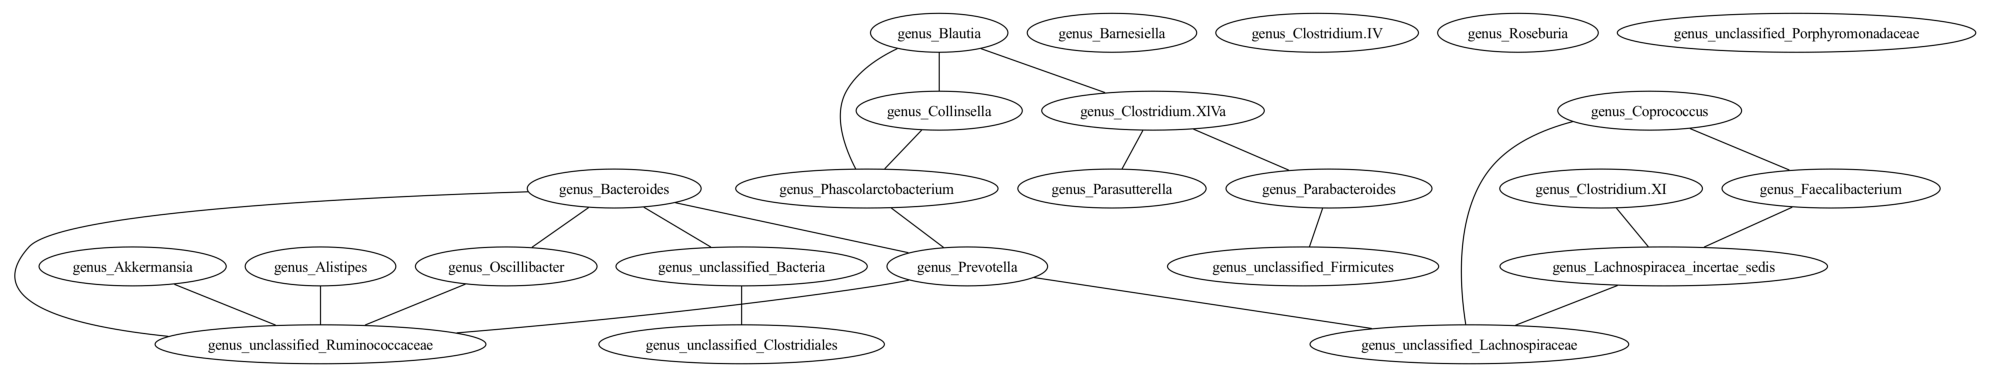

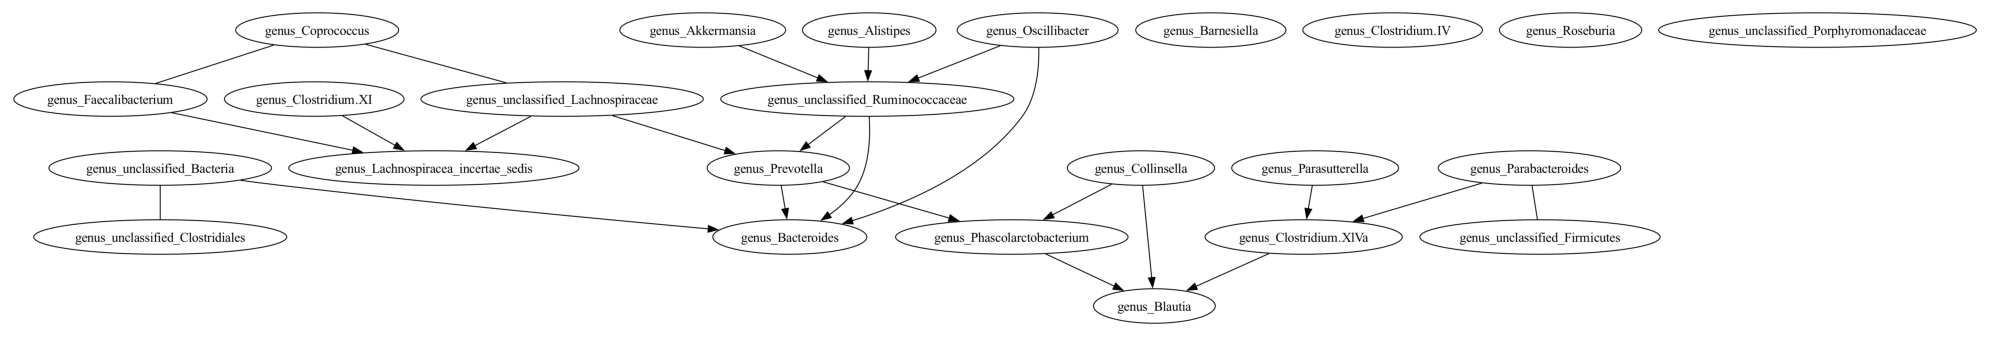

In [73]:
run_pc_depth2(healthy, data_sparse_healthy)

  0%|          | 0/24 [00:00<?, ?it/s]

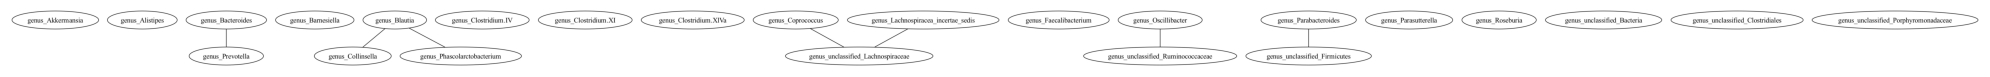

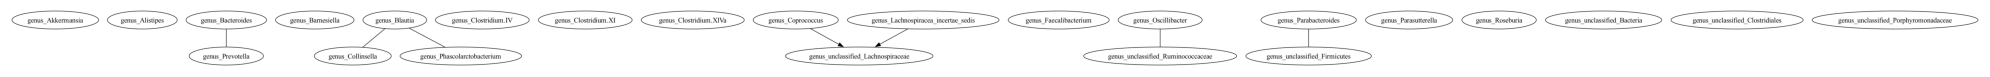

In [76]:
run_pc_depth2(healthy, data_sparse_healthy, alpha=0.05 / (healthy.shape[1] * (healthy.shape[1] - 1)))

  0%|          | 0/24 [00:00<?, ?it/s]

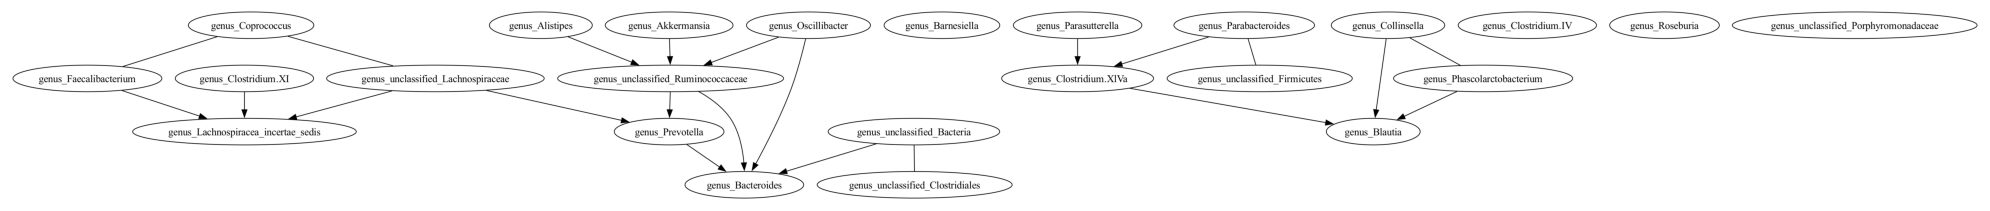

In [36]:
run_pc_fulldepth(healthy)

  0%|          | 0/24 [00:00<?, ?it/s]

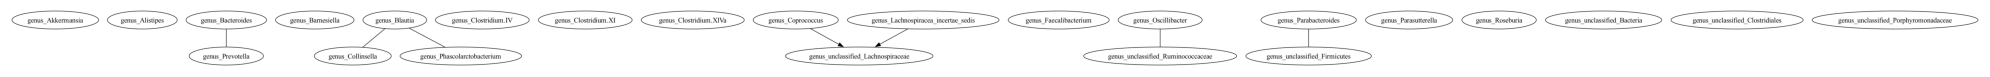

In [116]:
run_pc_fulldepth(healthy, 0.05 / (healthy.shape[1] * (healthy.shape[1] - 1)))

  0%|          | 0/25 [00:00<?, ?it/s]

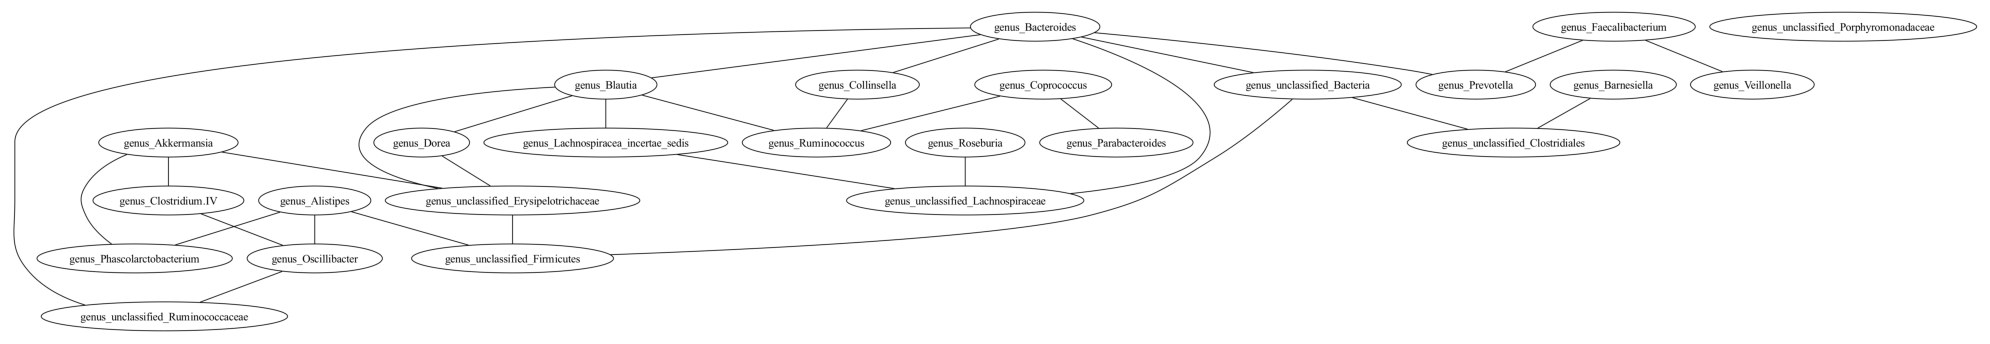

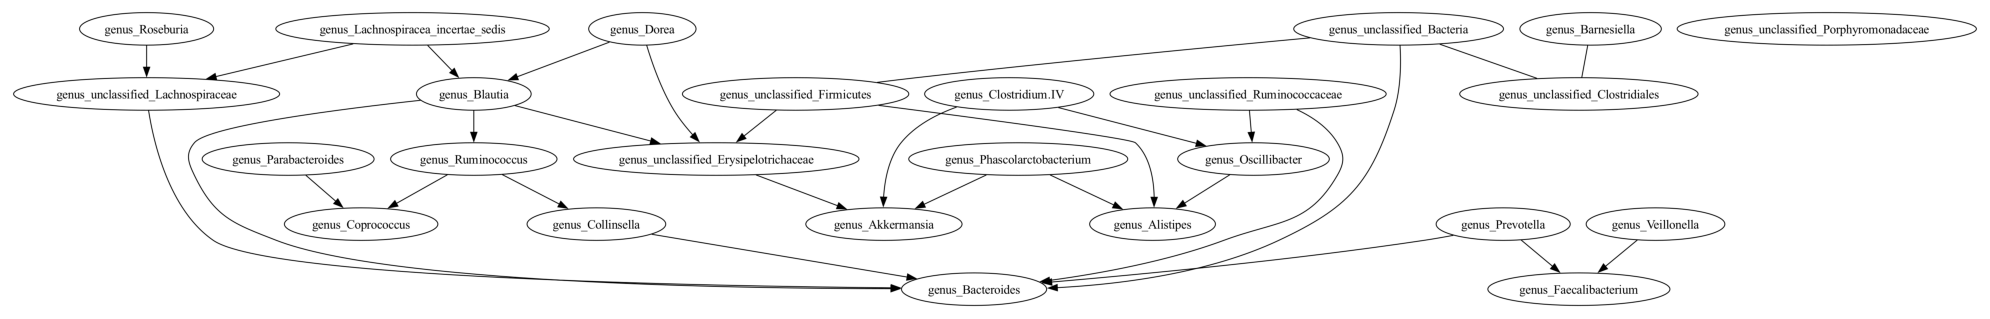

In [77]:
run_pc_depth2(diseased, data_sparse_diseased)

  0%|          | 0/25 [00:00<?, ?it/s]

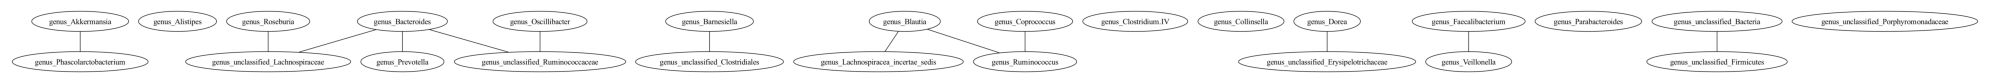

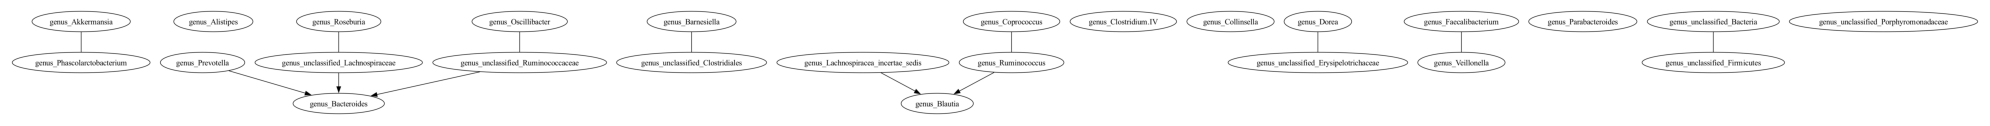

In [78]:
run_pc_depth2(diseased, data_sparse_diseased, alpha=0.05 / (diseased.shape[1] * (diseased.shape[1] - 1)))

  0%|          | 0/25 [00:00<?, ?it/s]

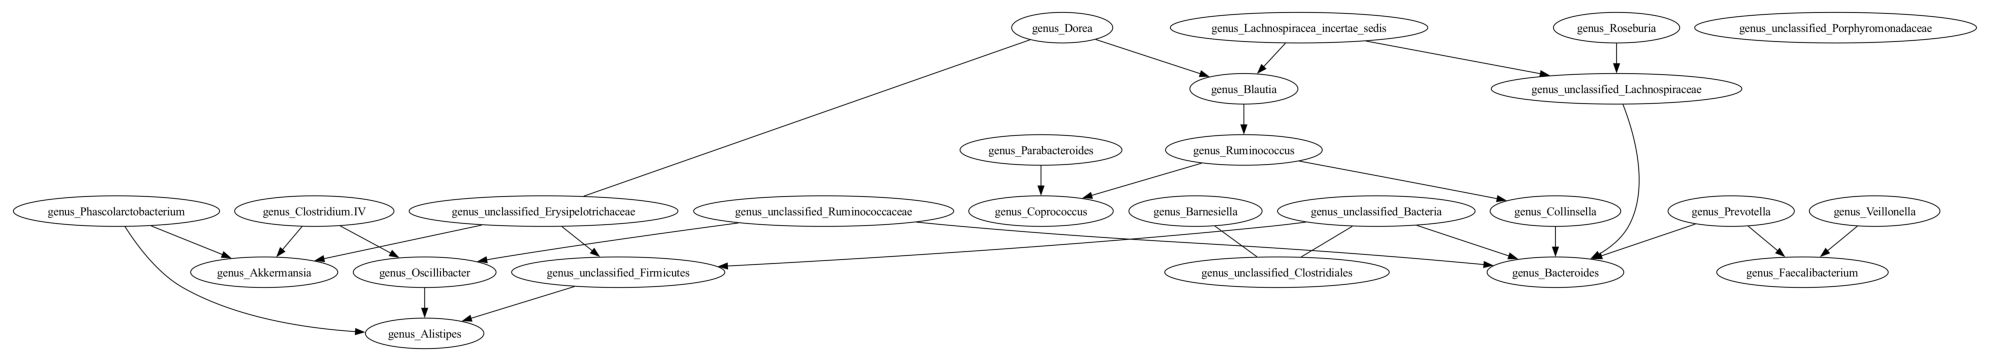

In [120]:
run_pc_fulldepth(diseased)

  0%|          | 0/25 [00:00<?, ?it/s]

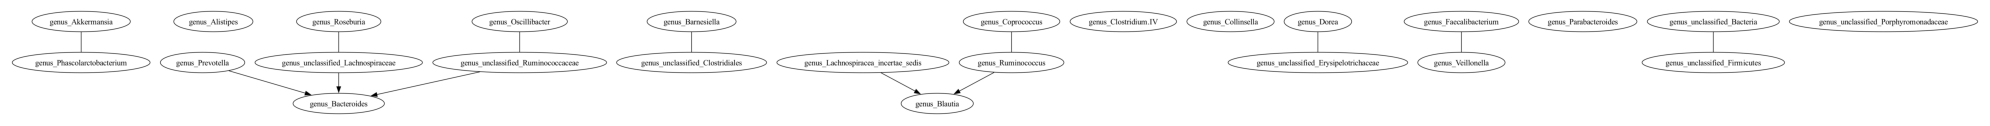

In [121]:
run_pc_fulldepth(diseased, 0.05 / (diseased.shape[1] * (diseased.shape[1] - 1)))

Bacteroides -- Parabacteroides
Alistipes -- unclassified Porphyromonadaceae
unclassified Clostridiales -- unclassified Porphyromonadaceae